# Notebook setup

In [3]:
if 'google.colab' in str(get_ipython()):
  IN_COLLAB = True
else:
  IN_COLLAB = False

#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"

if IN_COLLAB:
  from google.colab import drive
  drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# install required modules quietly
required_packages = ['azure-storage-blob', 'kaleido']

for p in required_packages: 
  try:
      __import__(p)
  except ImportError:
      %pip install {p} --quiet

from calendar import monthrange
from datetime import datetime
from datetime import timedelta
import pandas as pd
import math
import os
import json

import kaleido
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Load locale custome modules
import sys
if IN_COLLAB:
  os.chdir(MY_HOME_ABS_PATH)
  sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
  sys.path.append(os.path.abspath("./code/src/tools"))
from data_pipeline_lib import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [5]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
img_dir = data_dir + os.sep + 'figures'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

if IN_COLLAB:
  raw_data_dir = "/content/drive/MyDrive/CO2_flux_gpp_modeling/DS_capstone_23Spring_CO2/Data/half_hourly_data"

site_metadata_filename = data_dir + os.sep + 'site-metadata.csv'

In [6]:
# "Golden" Sites
train_sites = ["US-UMB", "US-Vcp", "US-Me2", "US-NR1", "FI-Hyy", "IT-Lav",
               "FR-Pue", "CH-Lae", "US-Var", "US-Wkg", "US-ARM", 
               "ES-LJu", "US-Ton", "US-SRM"]

# Selected Test Sites
test_sites = ["US-GLE", # ENF, Cold
              "US-AR1", # GRA, Temperate
              "US-Seg", # GRA, Arid
              "US-FR2", # WSA, Temperate
              "ES-LM2", # WSA, Arid
              "CA-Cbo", # DBF, Cold
              "FR-Lam", # CRO, Temperate
              "IT-Cpz", # EBF, Temperate
              "CN-Cha", # MF Cold
              "IT-Lsn", # OSH, Temperate
              ]

target_sites = train_sites + test_sites

# Load Site Metadata

In [9]:
# Load Site data
site_metadata_df = pd.read_csv(site_metadata_filename, usecols=['site_id', 'filename', 'IGBP'])

# only focus on target sites
print(f"size:{site_metadata_df.shape}")
site_metadata_df.dropna(inplace=True)
site_metadata_df

size:(286, 3)


,site_id,IGBP,filename
0,AR-SLu,MF,data_full_half_hourly_raw_v0_1_AR-SLu.csv
1,AR-Vir,ENF,data_full_half_hourly_raw_v0_1_AR-Vir.csv
2,AT-Neu,GRA,data_full_half_hourly_raw_v0_1_AT-Neu.csv
3,AU-ASM,SAV,data_full_half_hourly_raw_v0_1_AU-ASM.csv
4,AU-Ade,WSA,data_full_half_hourly_raw_v0_1_AU-Ade.csv
5,AU-Cpr,SAV,data_full_half_hourly_raw_v0_1_AU-Cpr.csv
6,AU-Cum,EBF,data_full_half_hourly_raw_v0_1_AU-Cum.csv
7,AU-DaP,GRA,data_full_half_hourly_raw_v0_1_AU-DaP.csv
8,AU-DaS,SAV,data_full_half_hourly_raw_v0_1_AU-DaS.csv
9,AU-Dry,SAV,data_full_half_hourly_raw_v0_1_AU-Dry.csv


# Compute all site intervals

In [ ]:
def has_full_month_record(year, month, actual_record_count):
    if actual_record_count == 0:
        print(f"  {month:2}: none")
        return False
    
    expected_days = monthrange(year, month)
    expected_record_count = expected_days[1]*48
    if(expected_record_count != actual_record_count):
        #print(f"  {month:2}: expected-[{expected_record_count}], actual-[{actual_record_count}]")
        return False
    return True

def has_full_day_record(year, month, day, actual_record_count):
    if actual_record_count == 0:
        #print(f"    {month}/{day}: none")
        return False
    
    expected_record_count = 48
    if(expected_record_count != actual_record_count):
        print(f"    {month}/{day}: expected-[{expected_record_count}], actual-[{actual_record_count}]")
        return False
    return True

def plot_month_records(site_id, year, month, df):
    df.plot.bar(x='datetime', y='GPP_NT_VUT_REF', 
                    title=f'{site_id}:{year}.{month}',
                    figsize= (16,4))

FULL_YEAR_DATA_COUNT = 2*24*365 #17520
LEAP_YEAR_DATA_COUNT = 2*24*366 #17568

def get_intervals(site_id, site_df):
    intervals_df = pd.DataFrame(columns=['start', 'end', 'duration_days','site_id'])
    start_year, end_year = get_min_max(site_df['year'])
    interval_start, interval_end = None, None

    for y in range(int(start_year), int(end_year)+1):
        year_df = site_df.loc[site_df['year'] == y]
        start_date, end_date = get_min_max_datetime(year_df['datetime'])
        date_delta = (end_date - start_date)
        
        if year_df.shape[0] == 0:
          if interval_start != None:
            interval_end = datetime(y, 1, 1, 23, 30, 0) - timedelta(days=1)
            if interval_end >=  interval_start:
                  delta = interval_end - interval_start
                  interval_data = {'start':interval_start,
                                    'end':interval_end,
                                    'duration_days': delta.days+1,
                                    'site_id':site_id}
                  intervals_df = intervals_df.append(interval_data, ignore_index=True)     
                  print(f"    int: {interval_start} - {interval_end} ({delta} == {delta.days+1})")
                  interval_start = None
                  interval_end = None
          #print(f"{y}: none")
          continue
        
        if (not start_date.is_leap_year and year_df.shape[0] != FULL_YEAR_DATA_COUNT) or\
           (start_date.is_leap_year and year_df.shape[0] != LEAP_YEAR_DATA_COUNT):
            #print(f"{y}: {year_df.shape[0]} ({start_date.date()}~{end_date.date()} {date_delta}) {'Leap' if start_date.is_leap_year else ''}")
            
            for m in range(1,13):
                if not (y == start_year and m < start_date.month):
                    month_df = year_df.loc[year_df['month'] == m]
                    if month_df.shape[0] == 0:
                      if interval_start != None:
                        interval_end = datetime(y, m, 1, 23, 30, 0) - timedelta(days=1)
                        if interval_end >=  interval_start:
                            delta = interval_end - interval_start
                            interval_data = {'start':interval_start,
                                              'end':interval_end,
                                              'duration_days': delta.days+1,
                                              'site_id':site_id}
                            intervals_df = intervals_df.append(interval_data, ignore_index=True)     
                            print(f"    int: {interval_start} - {interval_end} ({delta} == {delta.days+1})")
                            interval_start = None
                            interval_end = None
                      #print(f"  {m:2}: none")
                      continue
                    if not has_full_month_record(y, m, month_df.shape[0]):                           
                        for d in range(1, monthrange(y, m)[1]+1):
                            if not (y == start_year and m <= start_date.month and d < start_date.day):
                                day_df = month_df.loc[month_df['day'] == d]
                                if not has_full_day_record(y, m, d, day_df.shape[0]):
                                    if interval_start != None:
                                        interval_end = datetime(y, m, d, 23, 30, 0) - timedelta(days=1)
                                        if interval_end >=  interval_start:
                                            delta = interval_end - interval_start
                                            interval_data = {'start':interval_start,
                                                             'end':interval_end,
                                                             'duration_days': delta.days+1,
                                                             'site_id':site_id}
                                            intervals_df = intervals_df.append(interval_data, ignore_index=True)     
                                            print(f"    int: {interval_start} - {interval_end} ({delta} == {delta.days+1})")
                                            interval_start = None
                                            interval_end = None
                                elif interval_start == None:
                                    interval_start = datetime(y, m, d, 0, 0, 0)
                                    interval_end = None
                    elif interval_start == None:
                        interval_start = month_df['datetime'].min()
                        interval_end = None
                    
    if interval_start != None:
        interval_end = year_df['datetime'].max()
        delta = interval_end - interval_start
        interval_data = {'start':interval_start,
                         'end':interval_end,
                         'duration_days': delta.days+1,
                         'site_id':site_id}
        intervals_df = intervals_df.append(interval_data, ignore_index=True)     
        print(f"    int: {interval_start} - {interval_end} ({delta} == {delta.days+1})")
        interval_start = None
    return intervals_df

In [ ]:
# Iterate through sites
intervals_df = None
features = ['SITE_ID','TIMESTAMP_START', 'TIMESTAMP_END', 'datetime', 'date', 'year', 'month', 'day', 'hour', 'GPP_NT_VUT_REF']
for i, r in site_metadata_df[['site_id','filename']].iterrows():
    if not r.filename or type(r.filename) != type(""):
        print(f'\nERROR: {r.site_id} is mssing hourly data.')
        continue

    local_filename = raw_data_dir + os.sep + r.filename
    site_df = pd.read_csv(local_filename, usecols=features)
    site_df['datetime'] = pd.to_datetime(site_df['datetime'])
    
    print(f"\n{r.site_id}")
    if site_df.isna().sum().sum() != 0:
        print(f'{site_df.isna().sum()}\n')
        site_df.dropna(inplace=True)
    
    if site_df.shape[0] == 0:
      continue;

    site_interval_df = get_intervals(r.site_id, site_df)
    if type(intervals_df) == type(None):
        intervals_df = site_interval_df
    else:
        intervals_df = pd.concat([intervals_df, site_interval_df])

# merge with IGBP data
intervals_df = intervals_df.merge(site_metadata_df[['site_id', 'IGBP']], left_on = 'site_id', right_on = 'site_id')

# Save site_data checkpoint
intervals_df.to_csv(data_dir + os.sep + "all-sites-intervals.csv")


AR-SLu
    int: 2009-12-21 00:00:00 - 2011-03-26 23:30:00 (460 days, 23:30:00 == 461)

AR-Vir
    int: 2010-02-13 00:00:00 - 2010-06-13 23:30:00 (120 days, 23:30:00 == 121)
    int: 2010-06-30 00:00:00 - 2010-07-26 23:30:00 (26 days, 23:30:00 == 27)
    int: 2010-09-24 00:00:00 - 2011-02-20 23:30:00 (149 days, 23:30:00 == 150)
    int: 2011-05-01 00:00:00 - 2012-06-13 23:30:00 (409 days 23:30:00 == 410)

AT-Neu
    int: 2002-01-01 00:00:00 - 2002-02-03 23:30:00 (33 days 23:30:00 == 34)
    int: 2002-02-15 00:00:00 - 2003-01-14 23:30:00 (333 days, 23:30:00 == 334)
    int: 2003-01-25 00:00:00 - 2003-03-12 23:30:00 (46 days, 23:30:00 == 47)
    int: 2003-03-27 00:00:00 - 2004-01-20 23:30:00 (299 days, 23:30:00 == 300)
    int: 2004-02-15 00:00:00 - 2004-05-05 23:30:00 (80 days, 23:30:00 == 81)
    int: 2004-05-18 00:00:00 - 2006-03-11 23:30:00 (662 days, 23:30:00 == 663)
    int: 2006-03-28 00:00:00 - 2006-12-24 23:30:00 (271 days, 23:30:00 == 272)
    int: 2007-01-05 00:00:00 - 2012-12

# Stradified Split on Generalized IGBP

In [10]:
site_metadata_df.IGBP.unique()

array(['MF', 'ENF', 'GRA', 'SAV', 'WSA', 'EBF', 'WET', 'DBF', 'OSH',
       'CRO', 'CSH', 'WAT'], dtype=object)

In [11]:
site_metadata_df['gen_IGBP'] = site_metadata_df['IGBP']
site_metadata_df['gen_IGBP'].replace('WSA', 'SAV', inplace=True)
site_metadata_df['gen_IGBP'].replace('CSH', 'SHB', inplace=True)
site_metadata_df['gen_IGBP'].replace('OSH', 'SHB', inplace=True)
site_metadata_df.drop(site_metadata_df[site_metadata_df['gen_IGBP'] == 'WAT'].index, inplace = True)
site_metadata_df.gen_IGBP.unique()

array(['MF', 'ENF', 'GRA', 'SAV', 'EBF', 'WET', 'DBF', 'SHB', 'CRO'],
      dtype=object)

In [ ]:
# Define features and target variables of the data pipelines
target_variable = 'GPP_NT_VUT_REF'
target_variable_qc = 'NEE_VUT_REF_QC'
hourly_features = ['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                     'datetime', 'year', 'month', 'day', 'hour', 'date',
                     'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
metadata_features = ['site_id', 'filename', 'lat', 'long', 'koppen_sub', 'koppen_main', 'IGBP',
                     'c3c4', 'c4_percent', 'monthly_data_available']

# Define imput params
impute = True
impute_method = 'knn'
impute_global = True
resample = True
time_col = 'datetime'
duration = 'H'

# Filter sequence to date range
missing_thresh = 0.2
start_date = '2010-01-01'
end_date ='2015-12-31'
                 
def filter_date_range(df, start_date, end_date, time_col, missing_thresh=0.2):
    df.set_index(time_col, inplace=True)
    filtered_df = df.loc[start_date:end_date].copy()

    # Remove sites without at least one year of records
    if len(filtered_df) < 365*24:
        return None
    else:
        # Remove sites that have > 20% gaps in sequence
        first_date = filtered_df.index.min()
        last_date = filtered_df.index.max()
        total_expected_count = len(pd.date_range(start=first_date, end=last_date, freq='H'))
        missing_percentage = (total_expected_count - len(filtered_df)) / total_expected_count

        if missing_percentage > missing_thresh:
            return None
        else:
            filtered_df.reset_index(inplace=True)
            return filtered_df

available_sites = []
for i, r in site_metadata_df.iterrows():        
  if not r.filename or type(r.filename) != type(""):
    print(f'ERROR: {r.site_id} is missing hourly data.')
    continue
  
  # Prepare hourly site df
  local_filename = raw_data_dir + os.sep + r.filename
  site_df = pd.read_csv(local_filename, usecols = [target_variable, target_variable_qc] + hourly_features)

  # Format columns
  site_df['datetime'] = pd.to_datetime(site_df['datetime'])
  site_df['date'] = pd.to_datetime(site_df['date'])
  site_df['minute'] = site_df['datetime'].dt.minute
  if len(target_variable_qc) != 0:
      site_df[target_variable_qc] = site_df[target_variable_qc].astype('int')
  site_df['site_id'] = r.site_id

  # Move from HH to H level
  site_df = site_df.loc[site_df['datetime'].dt.minute == 0, ].copy()
  site_df.drop('minute', axis=1, inplace=True)

  # Filter site date-range and drop sites without > 1 year and <20% gaps after trim
  if start_date is not None and end_date is not None:
    site_df = filter_date_range(site_df, start_date, end_date, time_col, missing_thresh)
  
  if site_df is None:
      continue
  else:
    available_sites.append(r.site_id)

print(available_sites)

['AR-SLu', 'AR-Vir', 'AT-Neu', 'AU-ASM', 'AU-Cpr', 'AU-Cum', 'AU-DaP', 'AU-DaS', 'AU-Emr', 'AU-GWW', 'AU-Gin', 'AU-How', 'AU-RDF', 'AU-Rig', 'AU-Rob', 'AU-Stp', 'AU-TTE', 'AU-Whr', 'AU-Wom', 'CA-Oas', 'CA-TP1', 'CA-TP3', 'CA-TPD', 'CN-Sw2', 'CZ-BK2', 'DE-Lnf', 'DE-SfN', 'DE-Spw', 'DE-Zrk', 'ES-Amo', 'FI-Sod', 'FR-Pue', 'IT-CA1', 'IT-CA2', 'IT-CA3', 'IT-Isp', 'IT-Noe', 'IT-Ro2', 'IT-SRo', 'NL-Hor', 'US-GLE', 'US-IB2', 'US-Me6', 'US-Myb', 'US-NR1', 'US-SRM', 'US-Syv', 'US-Ton', 'US-Tw3', 'US-Twt', 'US-Var', 'US-WCr', 'US-WPT', 'US-Whs', 'US-Wkg', 'CA-Ca1', 'CA-Ca2', 'CA-Ca3', 'CA-Cbo', 'CA-Gro', 'CA-TP4', 'US-AR1', 'US-AR2', 'US-ARM', 'US-Bar', 'US-CRT', 'US-Fmf', 'US-Ho1', 'US-KFS', 'US-Mpj', 'US-Oho', 'US-Prr', 'US-Ro1', 'US-Rws', 'US-SRG', 'US-Seg', 'US-Ses', 'US-Tw4', 'US-UMB', 'US-UMd', 'US-Vcm', 'US-Vcp', 'US-Wjs', 'BE-Bra', 'BE-Dor', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CH-Lae', 'CH-Oe2', 'CZ-BK1', 'CZ-KrP', 'CZ-Lnz', 'CZ-RAJ', 'CZ-Stn', 'CZ-wet', 'DE-Geb', 'DE-Gri',

In [7]:
available_sites = ['AR-SLu', 'AR-Vir', 'AT-Neu', 'AU-ASM', 'AU-Cpr', 'AU-Cum',
       'AU-DaP', 'AU-DaS', 'AU-Emr', 'AU-Gin', 'AU-How', 'AU-RDF',
       'AU-Rig', 'AU-Stp', 'AU-TTE', 'AU-Whr', 'AU-Wom', 'BE-Bra',
       'BE-Dor', 'BE-Lon', 'BE-Vie', 'CA-Ca1', 'CA-Ca2', 'CA-Ca3',
       'CA-Cbo', 'CA-Gro', 'CA-Oas', 'CA-TP1', 'CA-TP3', 'CA-TP4',
       'CA-TPD', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CH-Lae', 'CH-Oe2',
       'CN-Sw2', 'CZ-BK1', 'CZ-BK2', 'CZ-KrP', 'CZ-Lnz', 'CZ-RAJ',
       'CZ-Stn', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH',
       'DE-Hte', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-SfN',
       'DE-Spw', 'DE-Tha', 'DK-Sor', 'ES-Amo', 'ES-LJu', 'ES-LM1',
       'ES-LM2', 'FI-Hyy', 'FI-Let', 'FI-Sod', 'FR-Aur', 'FR-Bil',
       'FR-FBn', 'FR-Fon', 'FR-Hes', 'FR-Lam', 'FR-Pue', 'GF-Guy',
       'IL-Yat', 'IT-BCi', 'IT-CA1', 'IT-CA2', 'IT-CA3', 'IT-Lav',
       'IT-MBo', 'IT-Noe', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo',
       'IT-Tor', 'NL-Hor', 'NL-Loo', 'RU-Fyo', 'SE-Deg', 'SE-Htm',
       'SE-Lnn', 'SE-Nor', 'SE-Ros', 'US-AR1', 'US-AR2', 'US-ARM',
       'US-Bar', 'US-CRT', 'US-Fmf', 'US-GLE', 'US-Ho1', 'US-IB2',
       'US-KFS', 'US-Me6', 'US-Mpj', 'US-Myb', 'US-NR1', 'US-Oho',
       'US-Prr', 'US-Ro1', 'US-Rws', 'US-SRG', 'US-SRM', 'US-Seg',
       'US-Ses', 'US-Syv', 'US-Ton', 'US-Tw4', 'US-Twt', 'US-UMB',
       'US-UMd', 'US-Var', 'US-Vcm', 'US-Vcp', 'US-WCr', 'US-WPT',
       'US-Whs', 'US-Wjs', 'US-Wkg']

In [12]:
site_data_df = site_metadata_df.loc[site_metadata_df['site_id'].isin(available_sites)]
site_data_df.shape

(129, 4)

In [14]:
from sklearn.model_selection import StratifiedKFold
n = 5
skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42) # Add random state for reproducibility
folds = skf.split(site_data_df['site_id'], site_data_df['gen_IGBP'])

site_splits = []

for i, (train_index, test_index) in enumerate(folds):
  print(f"Fold {i+1}:")
  data_df = site_data_df[['site_id', 'gen_IGBP']].iloc[test_index]
  sites = list(data_df.site_id.unique())
  print(f"  Count={test_index.shape}")
  print(f"  IGBP ={np.sort(data_df.gen_IGBP.unique())}")
  print(f"  Sites={sites}")
  print("")

  site_splits.append(sites)

Fold 1:
  Count=(26,)
  IGBP =['CRO' 'DBF' 'EBF' 'ENF' 'GRA' 'MF' 'SAV' 'SHB' 'WET']
  Sites=['AR-SLu', 'AU-ASM', 'AU-Cpr', 'AU-Cum', 'AU-RDF', 'CA-TP3', 'CA-TPD', 'CN-Sw2', 'DE-SfN', 'NL-Hor', 'US-Me6', 'US-Syv', 'US-WCr', 'US-AR2', 'US-Tw4', 'US-UMB', 'US-Vcp', 'CH-Cha', 'CZ-BK1', 'CZ-KrP', 'DE-Obe', 'ES-LJu', 'FI-Let', 'FR-Lam', 'IT-Lav', 'SE-Lnn']

Fold 2:
  Count=(26,)
  IGBP =['CRO' 'DBF' 'EBF' 'ENF' 'GRA' 'MF' 'SAV' 'SHB' 'WET']
  Sites=['CZ-BK2', 'DE-Spw', 'FR-Pue', 'IT-CA3', 'IT-Noe', 'IT-Ro2', 'US-IB2', 'US-Myb', 'US-SRM', 'CA-Ca3', 'US-CRT', 'US-Fmf', 'US-KFS', 'US-Prr', 'US-UMd', 'US-Wjs', 'BE-Bra', 'BE-Lon', 'CH-Lae', 'CZ-RAJ', 'DE-HoH', 'DE-Kli', 'DE-RuR', 'IL-Yat', 'IT-Tor', 'SE-Htm']

Fold 3:
  Count=(26,)
  IGBP =['CRO' 'DBF' 'EBF' 'ENF' 'GRA' 'MF' 'SAV' 'SHB' 'WET']
  Sites=['AR-Vir', 'AT-Neu', 'AU-DaS', 'AU-TTE', 'AU-Wom', 'CA-TP1', 'IT-CA1', 'IT-SRo', 'US-WPT', 'US-Wkg', 'CA-Ca2', 'CA-Cbo', 'CA-TP4', 'US-ARM', 'US-Ro1', 'US-Rws', 'US-SRG', 'US-Vcm', 'BE-Dor', 'BE-Vi

# Plot timelines

In [15]:
# Load site info from file.
intervals_df = pd.read_csv(data_dir + os.sep + "all-sites-intervals.csv")

## By Baseline Sites

In [ ]:
plot_df = intervals_df[intervals_df['site_id'].isin(target_sites)]
print(f"Data size: {plot_df.shape}")
fig = px.timeline(plot_df, x_start="start", x_end="end", y='site_id', color="IGBP",
                  category_orders ={
                      "site_id": target_sites
                  })
fig.update_yaxes(title_text = "", title_standoff = 0,
                 showticklabels=True,) # otherwise tasks are listed from the bottom up
fig.update_layout(title={'text': "Recorded Timeline per Site (Baseline Dataset)",
                         'y':0.95,'x':0.5},
                  height = 600, width = 1000,
                  legend_title_text= "IGBP<br>Classification",
                  legend_orientation="v",
                  template='plotly_white')

newnames = {
    'ENF': 'Evergreen Needleleaf Forests',
    'EBF': 'Evergreen Broadleaf Forests',
    'DNF': 'Deciduous Needleleaf Forests', 
    'DBF': 'Deciduous Broadleaf forests',
    'MF' : 'Mixed Forests',
    'CSH': 'Closed Shrublands',
    'OSH': 'Open Shrublands',
    'WSA': 'Woody Savannas',
    'SAV': 'Savannas',
    'GRA': 'Grasslands',
    'CRO': 'Croplands',
    'CVM': 'Cropland/<br>Natural Vegetation Mosaics',
    'WET': 'Permanent wetlands',
    'URB': 'Urban and Built-up Lands',
    'SNO': 'Snow and Ice',
    'BSV': 'Barren',
    'WAT': 'Water Bodies',}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()
fig.write_image(img_dir + os.sep + "Timeline_baseline_sites.png")

Data size: (248, 6)


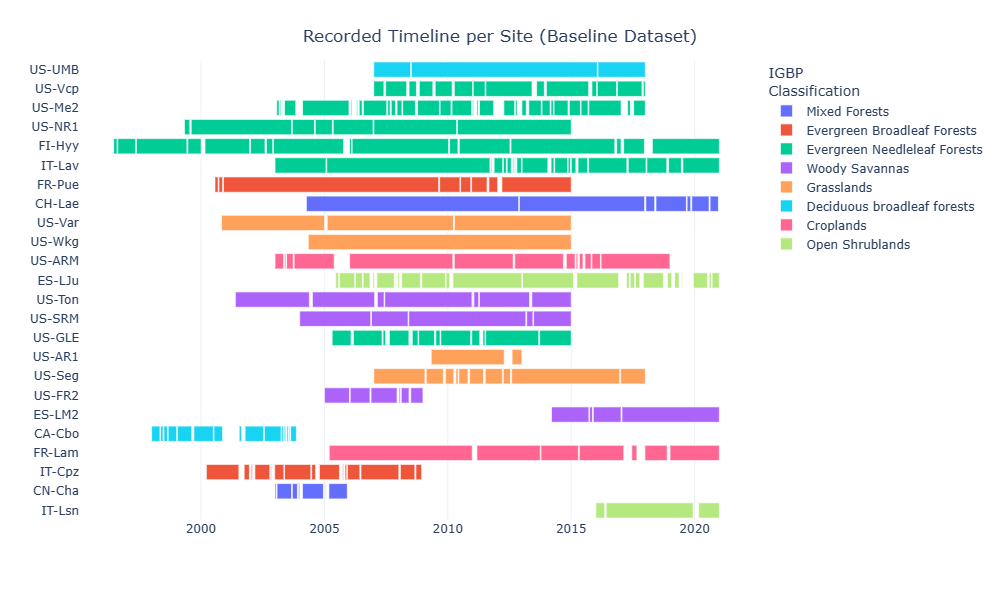

## By IGBP

In [ ]:
plot_df = intervals_df[intervals_df['IGBP'].isin(['ENF', 'EBF', 'DNF', 'DBF', 'MF'])]
print(f"Data size: {plot_df.shape}")
fig = px.timeline(plot_df, x_start="start", x_end="end", y='site_id', color="IGBP")
fig.update_yaxes(title_text = "", title_standoff = 0,
                 showticklabels=True,) # otherwise tasks are listed from the bottom up
fig.update_layout(title={'text': "Record Timeline per Forest Sites",
                         'y':0.95,'x':0.5},
                  height = 600, width = 1000,
                  legend_title_text= "IGBP<br>Classification",
                  legend_orientation="v",
                  template='plotly_white')

newnames = {
    'ENF': 'Evergreen Needleleaf Forests',
    'EBF': 'Evergreen Broadleaf Forests',
    'DNF': 'Deciduous Needleleaf Forests', 
    'DBF': 'Deciduous Broadleaf forests',
    'MF' : 'Mixed Forests',}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()
fig.write_image(img_dir + os.sep + "Timeline_forest_sites.png")

Data size: (1312, 6)


In [ ]:
plot_df = intervals_df[intervals_df['IGBP'].isin(['CSH', 'OSH'])]
print(f"Data size: {plot_df.shape}")
fig = px.timeline(plot_df, x_start="start", x_end="end", y='site_id', color="IGBP")
fig.update_yaxes(title_text = "", title_standoff = 0,
                 showticklabels=True,) # otherwise tasks are listed from the bottom up
fig.update_layout(title={'text': "Record Timeline per Shrublands Sites",
                         'y':0.95,'x':0.5},
                  height = 600, width = 1000,
                  legend_title_text= "IGBP<br>Classification",
                  legend_orientation="v",
                  template='plotly_white')

newnames = {
    'CSH': 'Closed Shrublands',
    'OSH': 'Open Shrublands',}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()
fig.write_image(img_dir + os.sep + "Timeline_shrublands_sites.png")

Data size: (143, 6)


In [ ]:
plot_df = intervals_df[intervals_df['IGBP'].isin(['WSA', 'SAV', 'GRA'])]
print(f"Data size: {plot_df.shape}")
fig = px.timeline(plot_df, x_start="start", x_end="end", y='site_id', color="IGBP")
fig.update_yaxes(title_text = "", title_standoff = 0,
                 showticklabels=True,) # otherwise tasks are listed from the bottom up
fig.update_layout(title={'text': "Record Timeline per Grassland Sites",
                         'y':0.95,'x':0.5},
                  height = 600, width = 1000,
                  legend_title_text= "IGBP<br>Classification",
                  legend_orientation="v",
                  template='plotly_white')

newnames = {
    'WSA': 'Woody Savannas',
    'SAV': 'Savannas',
    'GRA': 'Grasslands'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()
fig.write_image(img_dir + os.sep + "Timeline_grassland_sites.png")

Data size: (366, 6)


In [ ]:
plot_df = intervals_df[intervals_df['IGBP'].isin(['CRO', 'CVM'])]
print(f"Data size: {plot_df.shape}")
fig = px.timeline(plot_df, x_start="start", x_end="end", y='site_id', color="IGBP")
fig.update_yaxes(title_text = "", title_standoff = 0,
                 showticklabels=True,) # otherwise tasks are listed from the bottom up
fig.update_layout(title={'text': "Record Timeline per Cropland Sites",
                         'y':0.95,'x':0.5},
                  height = 600, width = 1000,
                  legend_title_text= "IGBP<br>Classification",
                  legend_orientation="v",
                  template='plotly_white')

newnames = {
    'CRO': 'Croplands',
    'CVM': 'Cropland/<br>Natural Vegetation Mosaics',}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()
fig.write_image(img_dir + os.sep + "Timeline_cropland_sites.png")

Data size: (200, 6)


In [ ]:
plot_df = intervals_df[intervals_df['IGBP'].isin(['WET', 'URB'])]
print(f"Data size: {plot_df.shape}")
fig = px.timeline(plot_df, x_start="start", x_end="end", y='site_id', color="IGBP")
fig.update_yaxes(title_text = "", title_standoff = 0,
                 showticklabels=True,) # otherwise tasks are listed from the bottom up
fig.update_layout(title={'text': "Record Timeline per Wetland and Urban Sites",
                         'y':0.95,'x':0.5},
                  height = 600, width = 1000,
                  legend_title_text= "IGBP<br>Classification",
                  legend_orientation="v",
                  template='plotly_white')

newnames = {
    'WET': 'Permanent wetlands',
    'URB': 'Urban and Built-up Lands',}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()
fig.write_image(img_dir + os.sep + "Timeline_urban_sites.png")

Data size: (192, 6)


In [ ]:
plot_df = intervals_df[intervals_df['IGBP'].isin(['SNO', 'BSV', 'WAT'])]
print(f"Data size: {plot_df.shape}")
fig = px.timeline(plot_df, x_start="start", x_end="end", y='site_id', color="IGBP")
fig.update_yaxes(title_text = "", title_standoff = 0,
                 showticklabels=True,) # otherwise tasks are listed from the bottom up
fig.update_layout(title={'text': "Record Timeline per Barren or Sparsely Vegetated Sites",
                         'y':0.95,'x':0.5},
                  height = 600, width = 1000,
                  legend_title_text= "IGBP<br>Classification",
                  legend_orientation="v",
                  template='plotly_white')

newnames = {
    'SNO': 'Snow and Ice',
    'BSV': 'Barren',
    'WAT': 'Water Bodies',}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()
fig.write_image(img_dir + os.sep + "Timeline_barren_sites.png")

Data size: (0, 6)


## By Stratified Fold

In [16]:
for i, sites in enumerate(site_splits):
  plot_df = intervals_df[intervals_df['site_id'].isin(sites)]
  print(f"Data size: {plot_df.shape}")
  print(sites)
  fig = px.timeline(plot_df, x_start="start", x_end="end", y='site_id', color="IGBP",
                    category_orders ={
                        "IGBP": ['ENF', 'EBF', 'DBF', 'MF', 'SHB', 'SAV', 'GRA', 'WET', 'CRO']
                    })
  fig.update_yaxes(title_text = "", title_standoff = 0,
                  showticklabels=True,) # otherwise tasks are listed from the bottom up
  fig.update_layout(title={'text': f"Recorded Timeline per Site (Fold #{i+1})",
                          'y':0.95,'x':0.5},
                    height = 600, width = 1000,
                    legend_title_text= "IGBP<br>Classification",
                    legend_orientation="v",
                    template='plotly_white')

  newnames = {
      'ENF': 'Evergreen Needleleaf Forests',
      'EBF': 'Evergreen Broadleaf Forests',
      'DNF': 'Deciduous Needleleaf Forests', 
      'DBF': 'Deciduous Broadleaf forests',
      'MF' : 'Mixed Forests',
      'CSH': 'Closed Shrublands',
      'OSH': 'Open Shrublands',
      'WSA': 'Woody Savannas',
      'SAV': 'Savannas',
      'GRA': 'Grasslands',
      'CRO': 'Croplands',
      'CVM': 'Cropland/<br>Natural Vegetation Mosaics',
      'WET': 'Permanent wetlands',
      'URB': 'Urban and Built-up Lands',
      'SNO': 'Snow and Ice',
      'BSV': 'Barren',
      'WAT': 'Water Bodies',}
  fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                        legendgroup = newnames[t.name],
                                        hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                      )
                    )

  fig.show()
  fig.write_image(img_dir + os.sep + "Timeline_baseline_sites.png")

Data size: (255, 6)
['AR-SLu', 'AU-ASM', 'AU-Cpr', 'AU-Cum', 'AU-RDF', 'CA-TP3', 'CA-TPD', 'CN-Sw2', 'DE-SfN', 'NL-Hor', 'US-Me6', 'US-Syv', 'US-WCr', 'US-AR2', 'US-Tw4', 'US-UMB', 'US-Vcp', 'CH-Cha', 'CZ-BK1', 'CZ-KrP', 'DE-Obe', 'ES-LJu', 'FI-Let', 'FR-Lam', 'IT-Lav', 'SE-Lnn']


Data size: (234, 6)
['CZ-BK2', 'DE-Spw', 'FR-Pue', 'IT-CA3', 'IT-Noe', 'IT-Ro2', 'US-IB2', 'US-Myb', 'US-SRM', 'CA-Ca3', 'US-CRT', 'US-Fmf', 'US-KFS', 'US-Prr', 'US-UMd', 'US-Wjs', 'BE-Bra', 'BE-Lon', 'CH-Lae', 'CZ-RAJ', 'DE-HoH', 'DE-Kli', 'DE-RuR', 'IL-Yat', 'IT-Tor', 'SE-Htm']


Data size: (217, 6)
['AR-Vir', 'AT-Neu', 'AU-DaS', 'AU-TTE', 'AU-Wom', 'CA-TP1', 'IT-CA1', 'IT-SRo', 'US-WPT', 'US-Wkg', 'CA-Ca2', 'CA-Cbo', 'CA-TP4', 'US-ARM', 'US-Ro1', 'US-Rws', 'US-SRG', 'US-Vcm', 'BE-Dor', 'BE-Vie', 'CZ-Stn', 'DE-Geb', 'ES-LM2', 'FR-Fon', 'SE-Ros', 'DE-Hte']


Data size: (274, 6)
['AU-DaP', 'AU-Emr', 'AU-Gin', 'AU-How', 'AU-Rig', 'US-GLE', 'US-NR1', 'US-Twt', 'CA-Ca1', 'CA-Gro', 'US-AR1', 'US-Bar', 'US-Mpj', 'US-Ses', 'CH-Fru', 'CH-Oe2', 'DE-Hai', 'DK-Sor', 'FI-Hyy', 'FR-Aur', 'FR-Hes', 'GF-Guy', 'IT-SR2', 'SE-Deg', 'SE-Nor', 'NL-Loo']


Data size: (233, 6)
['AU-Stp', 'AU-Whr', 'CA-Oas', 'DE-Lnf', 'ES-Amo', 'FI-Sod', 'IT-CA2', 'US-Ton', 'US-Var', 'US-Whs', 'US-Ho1', 'US-Oho', 'US-Seg', 'CH-Dav', 'CZ-Lnz', 'CZ-wet', 'DE-Gri', 'DE-Tha', 'ES-LM1', 'FR-Bil', 'FR-FBn', 'IT-BCi', 'IT-MBo', 'IT-Ren', 'RU-Fyo']
